In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np


In [2]:
#using pretrained model RESNET, source: https://pytorch.org/hub/pytorch_vision_resnet/
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)

Using cache found in C:\Users\Ahmad/.cache\torch\hub\pytorch_vision_v0.4.2


In [22]:
data_dir = 'data' # Directory of your unzipped "signs" folder

batch_size = 64

total_data = 84898

train_qu = int(0.70 * total_data)
test_qu = int(0.15 * total_data)
valid_qu = total_data - (train_qu + test_qu)

# mean and std values are specified in https://pytorch.org/hub/pytorch_vision_resnet/
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])

#test_transforms = transforms.Compose([transforms.Resize((224, 224)),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(mean=mean, std=std)])

total_data = datasets.ImageFolder(data_dir, transform=train_transforms)
train_data, valid_data, test_data = torch.utils.data.random_split(total_data, [train_qu, valid_qu, test_qu]) # total data is 13440


trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_on_gpu = torch.cuda.is_available()

classes = ['closed', 'open']

________________________________

In [23]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plot = plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

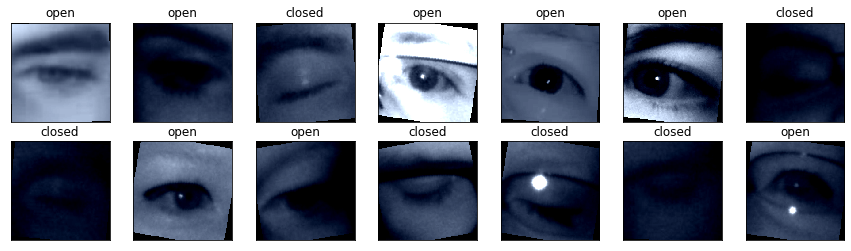

In [24]:
with torch.no_grad():
    dataiter = iter(testloader)
    test_images, test_labels = dataiter.next()
    test_images.numpy()

# displaying a random image
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(14):
    ax = fig.add_subplot(2, 14/2, idx+1, xticks=[], yticks=[])
    imshow(test_images.cpu()[idx])
    ax.set_title("{}".format(classes[test_labels[idx]]))

In [27]:
print(test_images[0].shape)
print('training on ' + ('GPU' if train_on_gpu else 'CPU'))

torch.Size([3, 224, 224])
training on GPU


In [28]:
####################
# Making The Model #
####################

# Stop tracking gradients to keep the parameters as it is
for param in model.parameters():
    param.require_grad = False

# edit fc "the last layer in the model" to suit our needs
#the layer has 512 input features
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 12),
                                 nn.LogSoftmax(dim=1))

if train_on_gpu:
    model.cuda()

In [29]:
###########################
# Criterion And Optimizer #
###########################

import torch.optim as optim
# Loss function chosen based on log soft max layer in the model
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [31]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'trained_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.010475 	Validation Loss: 0.031815
Validation loss decreased (inf --> 0.031815).  Saving model ...
Epoch: 2 	Training Loss: 0.009995 	Validation Loss: 0.029867
Validation loss decreased (0.031815 --> 0.029867).  Saving model ...
Epoch: 3 	Training Loss: 0.009463 	Validation Loss: 0.038346
Epoch: 4 	Training Loss: 0.008920 	Validation Loss: 0.036479
Epoch: 5 	Training Loss: 0.009048 	Validation Loss: 0.033555
Epoch: 6 	Training Loss: 0.007857 	Validation Loss: 0.035792
Epoch: 7 	Training Loss: 0.007987 	Validation Loss: 0.033716
Epoch: 8 	Training Loss: 0.007041 	Validation Loss: 0.033304
Epoch: 9 	Training Loss: 0.006820 	Validation Loss: 0.038323
Epoch: 10 	Training Loss: 0.006957 	Validation Loss: 0.036319
Epoch: 11 	Training Loss: 0.006889 	Validation Loss: 0.034372
Epoch: 12 	Training Loss: 0.006768 	Validation Loss: 0.032113
Epoch: 13 	Training Loss: 0.005545 	Validation Loss: 0.036357
Epoch: 14 	Training Loss: 0.005839 	Validation Loss: 0.033471
Epoch: 1

In [35]:
model.load_state_dict(torch.load('trained_model_RESNET18.pt'))

<All keys matched successfully>

In [36]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, predection = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = predection.eq(target.data.view_as(predection))
    # convert the output into a numpy array
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.029093

Test Accuracy of closed: 99% (6223/6277)
Test Accuracy of  open: 99% (6409/6457)

Test Accuracy (Overall): 99% (12632/12734)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

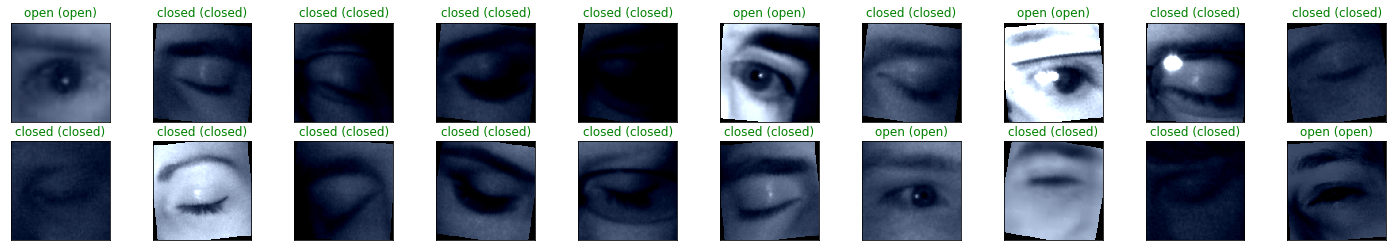

In [38]:
# obtain one batch of test images
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    images.numpy()

    if train_on_gpu:
        images = images.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, predection = torch.max(output, 1)
    # conver the predection tensor into a numpy array
    predection = predection.cpu().numpy() if train_on_gpu else predection.numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images.cpu()[idx])
        ax.set_title("{} ({})".format(classes[predection[idx]], classes[labels[idx]]),
                    color=("green" if predection[idx]==labels[idx].item() else "red"))